### * Model's Background:

* We train the model using ArcFace into order to,
    * Reduce the distance of intra features (features belong to same group) and
    * Increase the distance of inter features (features does not belong to same group).
* Above helps to well seperate the features and there bny increase the model's performance.
* #### Working of ArcFace:
    * Initially each classes are assigned a weight.
    * Then each feature and corresponding weight is normalized to get cosθj (i.e) logit for each class.
    * The normalisation step on features and weights makes the predictions only depend on the angle between the feature and the weight.
    * Using arccosθyi, angle between feature and weight is calculated.
    * By training, Weight of each class is moved to centre of features which belong to same class.
    * Then arc margin penalty m is added to target angle θyi.
    * This additive angular margin penalty m between xi and Wyi to simultaneously enhance the intra-class compactness and inter-class discrepancy. 
    * Then cos(θyi + m) (i.e logits) is calculated and it is multipled all by the feature scale 's'.

### * Model Pipeline:

In [1]:
import pandas as pd
import numpy as np
import joblib
import random
from sklearn.neighbors import NearestNeighbors
import scipy.sparse
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from IPython.display import Image
import math

import tensorflow as tf

In [3]:
def load_files():
    effnet_model = tf.keras.models.load_model('effnetb3_model', compile=False)
    image_embeddings = np.load('image_embeddings.npy')
    title_vectorizer = joblib.load('title_tfidf.pkl')
    title_embeddings = scipy.sparse.load_npz('title_embeddings.npz')
    return [effnet_model, image_embeddings, title_vectorizer, title_embeddings]

print('Loading pretrained models and weigths...')
pretrained_files = load_files()
print('Pretrained models and weigths are loaded..!')

Loading pretrained models and weigths...
Pretrained models and weigths are loaded..!


In [30]:
def decode_image(image_data):
    IMAGE_SIZE = [512, 512]
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def read_image(image):
    image = tf.io.read_file(image)
    image = decode_image(image)
    return image

def get_dataset(image):
    AUTO = tf.data.experimental.AUTOTUNE
    dataset = tf.data.Dataset.from_tensor_slices(image)
    dataset = dataset.map(read_image, num_parallel_calls = AUTO)
    dataset = dataset.batch(8)
    dataset = dataset.prefetch(AUTO)
    return dataset

def image_printer(original_image, similar_images):
    print('Given Image:\n')
    plt.figure(figsize = (5, 5))
    plt.imshow(mpimg.imread(original_image))
    plt.show()
    print()
    print('Similar Image(s):\n')
    
    figsize = (10, 10)
    length = len(similar_images)
    if (length > 4):
        col_len = 4 
        row_len = math.ceil(len(similar_images) / col_len)
        img_count = 0
        f1, axs1 = plt.subplots(nrows=row_len, ncols=col_len, figsize=figsize)
        for i in range(row_len):
            for j in range(col_len):
                if(img_count < len(similar_images)):
                    axs1[i, j].imshow(mpimg.imread('../Dataset/train_images/' + similar_images[img_count]))
                else:
                    f1.delaxes(axs1[i][j])
                img_count+=1
        plt.show()
    elif (length > 1 and length <= 4):
        img_count = 0
        f2, axs2 = plt.subplots(nrows=1, ncols=length, figsize=figsize)
        for i in range(length):
            if(img_count < len(similar_images)):
                axs2[i].imshow(mpimg.imread('../Dataset/train_images/' + similar_images[img_count]))
            else:
                f2.delaxes(axs2[i])
            img_count+=1
        plt.show()
    else:
        img_count = 0
        f3, axs3 = plt.subplots(nrows=1, ncols=1, figsize=(3, 3))
        axs3.imshow(mpimg.imread('../Dataset/train_images/' + similar_images[img_count]))
        plt.show()
    
    print('\n\n')

In [31]:
def show_similar_products(df, samples, pretrained_files):
    print('Started predicting....')
    image_path = '../Dataset/train_images/'
    images = [image_path + i for i in list(df.loc[samples].image)]
    titles = list(df.loc[samples].title)
    
    img_neighbors_model = NearestNeighbors(n_neighbors = 50, metric = 'cosine').fit(pretrained_files[1])
    txt_neighbors_model = NearestNeighbors(n_neighbors = 50, metric = 'cosine').fit(pretrained_files[3])
    
    for img, title in zip(images, titles):
        pred_image_embedding = pretrained_files[0].predict(get_dataset([img]))
        pred_title_embedding = pretrained_files[2].transform([title])
        
        image_distances, image_indices = img_neighbors_model.kneighbors(pred_image_embedding)
        title_distances, title_indices = txt_neighbors_model.kneighbors(pred_title_embedding)
        
        idx_image = np.where(image_distances[0] < 0.46)[0]
        ids_image = [image_indices[0][i] for i in idx_image]
        idx_title = np.where(title_distances[0] < 0.31)[0]
        idx_title = [title_indices[0][i] for i in idx_title]
        ids = list(set(list(ids_image) + list(idx_title)))
        
        similar_images = list(df['image'].iloc[ids].values)
        image_printer(img, similar_images)

In [34]:
df = pd.read_csv('../Dataset/train.csv')
samples = random.sample(range(len(df)), 10)
print('Sample Input Index:', samples)

Sample Input Index: [2188, 15270, 11366, 2813, 24395, 10726, 27430, 5400, 26574, 29188]


Started predicting....
Given Image:



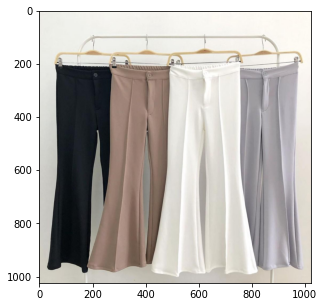


Similar Image(s):



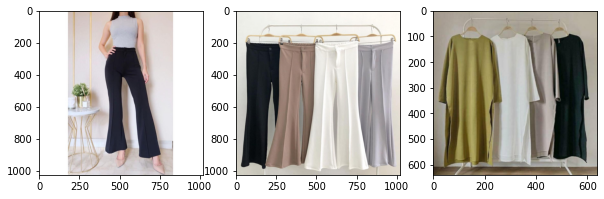




Given Image:



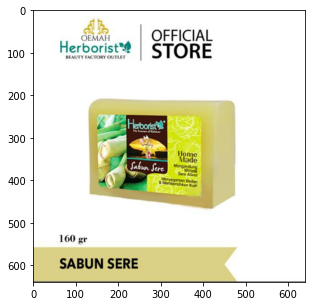


Similar Image(s):



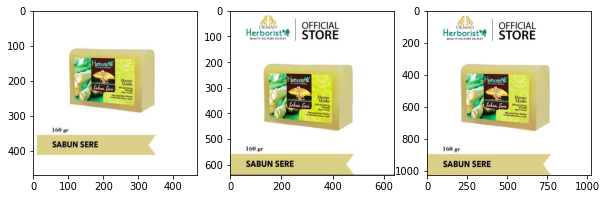




Given Image:



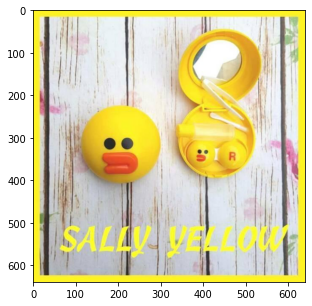


Similar Image(s):



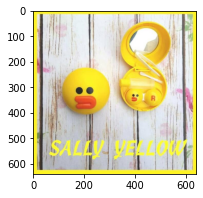




Given Image:



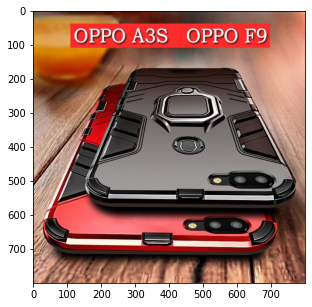


Similar Image(s):



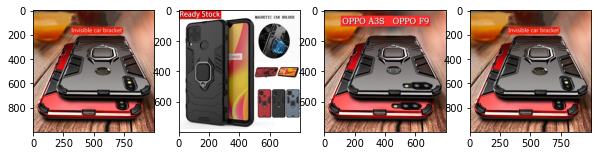




Given Image:



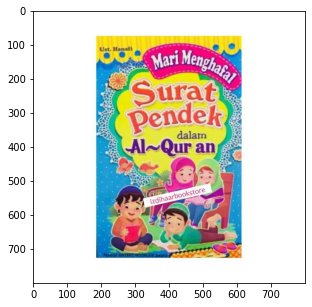


Similar Image(s):



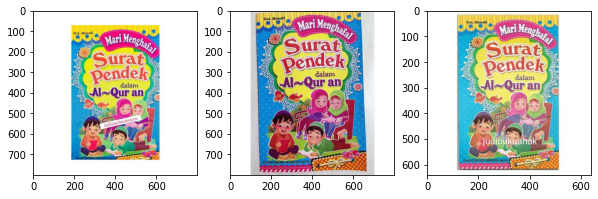




Given Image:



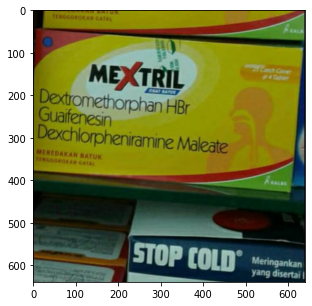


Similar Image(s):



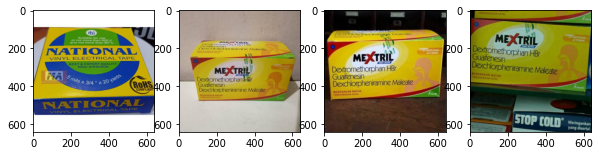




Given Image:



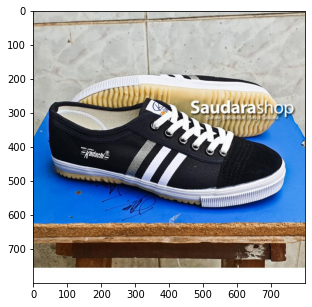


Similar Image(s):



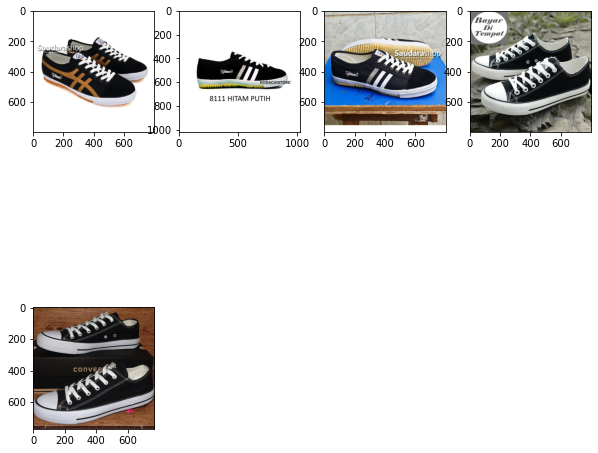




Given Image:



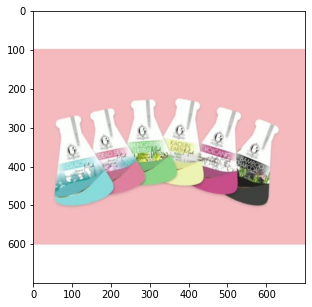


Similar Image(s):



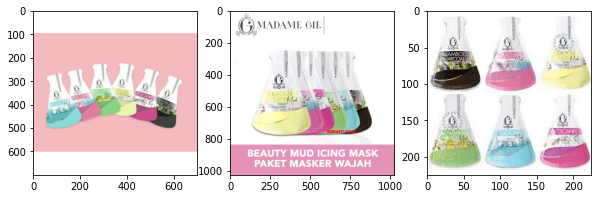




Given Image:



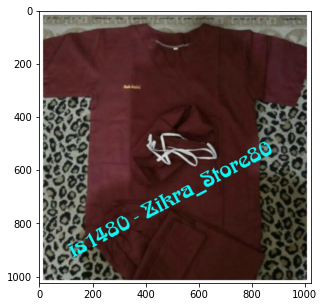


Similar Image(s):



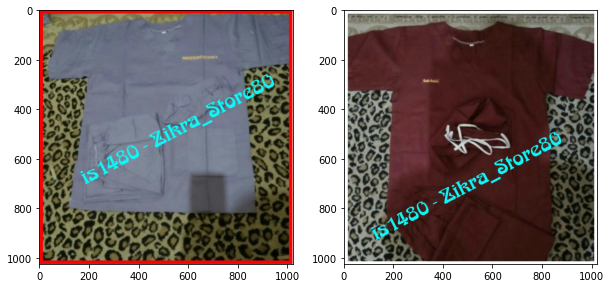




Given Image:



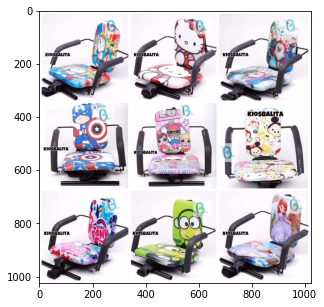


Similar Image(s):



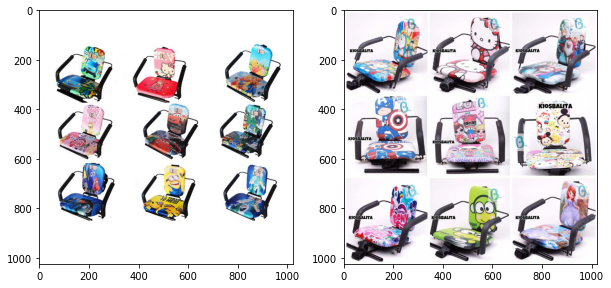

In [35]:
show_similar_products(df, samples, pretrained_files)